In [51]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import nengo
from nengo.utils.matplotlib import rasterplot
import seaborn as sns
sns.set_style("white")
sns.set_style("ticks")
plt.rcParams['figure.figsize'] = (10.0, 5.0)
plt.rcParams['lines.linewidth'] = 2
def prettify():
    sns.despine()
    plt.tight_layout()

# How to build a brain <br> with Python

### Trevor Bekolay

The human brain is an amazing computing device.
It weighs about 2 kilograms,
is composed of around 86 billion neurons,
on the order of a quadrillion connections between neurons,
and consumes about 20 watts of power.
Yet it's directly responsible for everything
humans have accomplished,
including creating computers,
and Python, which is why we're here today.
I'm a theoretical neuroscientist,
which means that I build computer
simulations of brains.
Today, I want to tell you how we use Python
to create and run those simulations.

<img src="img/feynman.png" class="center" width="80%">

<img src="img/astroboy.svg" class="inline" width="30%">
<img src="img/hal.svg" class="inline" width="20%">
<img src="img/skynet.svg" class="inline" width="20%">

It's worth first talking about why we want to model the brain.
The first is to understand the brain.
The late Richard Feynman wrote this
shortly before his passing:
"What I cannot create, I do not understand."
We think that the best way to understand
how the brain works is to try to
do what the brain does,
under the same types of constraints that
the brain works under.

The second reason is to leverage
this understanding to build better
artificial intelligences.
There are both optimistic and pessimistic
examples of AIs in science fiction.
I think what worries most people,
and what makes things like Hal and Skynet
seem plausible,
is that these intelligences are not brain-like;
they magically emerged from some research project,
and they can't be reasoned with.
I hope to convince you that this type of
emergent superintelligence is not realistic;
we have to engineer intelligence,
it won't just happen,
and that means we know a lot about it
and can reason with it.

<img src="img/neuron.png" class="center">

In [2]:
!neurondemo

NEURON -- VERSION 7.3 ansi (1078:2b0c984183df) 2014-04-04
Duke, Yale, and the BlueBrain Project -- Copyright 1984-2014
See http://www.neuron.yale.edu/neuron/credits

loading membrane mechanisms from /usr/local/Cellar/neuron/7.3/share/nrn/demo/release/x86_64/.libs/libnrnmech.so
Additional mechanisms from files
 cabpump.mod cachan1.mod camchan.mod capump.mod invlfire.mod khhchan.mod mcna.mod nacaex.mod nachan.mod release.mod
oc>

Let's get right into it.
The software that we're going to look
at today are called "neural simulators,"
as they're simulating neural systems like the brain.
I want to begin with one of the first neural simulators,
which is still actively developed and used today,
called NEURON.

NEURON was how I was introduced to a lot of
the elements of neuroscience,
since it does a good job of emulating
real biological neurons.
Let's start up the demo that comes with NEURON.

You can see right off the bat,
this is an old program,
copyright 1984,
which is before I was born.
It looks old. But it works;
let's start with the Pyramidal demo,
which loads up this neuron.
Here we can see some of the parts of a neuron.
These processes around the outside here
are called dendrites, and they are essentially
the inputs to the cell;
there can be many dendrites for each cell.
The body of the cell is called the soma.
And then every cell has a single output process
called an axon, which also branches out.

Right now,
NEURON is doing a "current clamp" experiment,
which mimics actual neuroscientific experiments.
There is a simulated electrode, here in the soma
at the blue dot.
*Show parameters*
It's delivering a current pulse
of 10 nanoamps for 0.5 milliseconds,
with no delay.
Let's run this experiment.
What's being plotted here is the
membrane potential -- the voltage -- at 
the soma.
This quick up and down portion
is called an action potential,
or a "spike",
and these spikes are how neurons
communicate to each other.

We can lower the amplitude of the
injected current to 3 nanoamps,
and you'll see that we no longer get a spike.
We can raise it to 20, and the only difference is that
we get a spike earlier.

Another thing we can do is change
where we're injecting current.
If we inject current in this dendride,
then even 20 nanoamps is no longer
sufficient to cause a spike.
Let's close this down.

In [7]:
import neuron

soma = neuron.h.Section()
soma.L = 40  # Length in um
soma.diam = 20  # Diameter in um
soma.insert('hh')

dendrite = neuron.h.Section()
dendrite.L = 150
dendrite.diam = 3
dendrite.insert('pas')

dendrite.connect(soma, 0, 1)  # connect soma(0) with dendrite(1);

In [8]:
stim = neuron.h.IClamp(soma(0.5))
stim.delay = 0
stim.amp = 5  # In nA
stim.dur = 0.5

rec_t = neuron.h.Vector()
rec_t.record(neuron.h._ref_t)

rec_v = neuron.h.Vector()
rec_v.record(soma(0.5)._ref_v);

In [9]:
neuron.h.finitialize(-60)
neuron.init()
neuron.run(5)

NEURON has Python bindings, so we can
do this with Python instead.
I'll do a much simplified model here,
just a soma and a single dendrite.
Here, we're setting the parameters of the soma and dendrite,
the length and diameter,
and adding passive dynamics.
Then we connect them together.

Next, we set up our current clamp experiment,
clamping at half the soma length,
and injecting 5 nanoamps of current for 0.5 milliseconds.
We the set up these vectors to record the time (ref_t)
and the voltage at the center of the soma (ref_v).
We set the initial voltage of everything to -60 millivolts,
and run the simulation for 5 milliseconds.

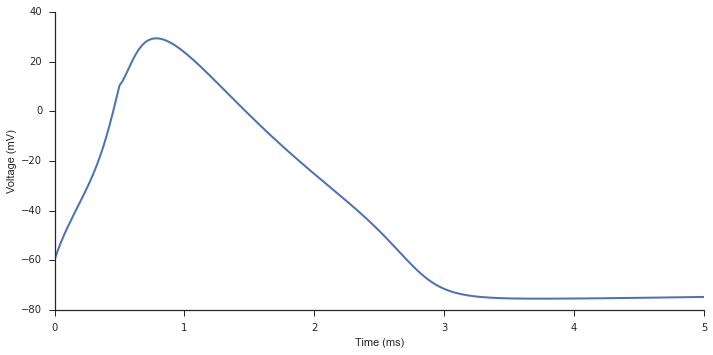

In [47]:
import matplotlib.pyplot as plt
import numpy as np

times = np.array(rec_t)
voltages = np.array(rec_v)

plt.plot(times, voltages)
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (mV)")
plt.xlim(right=5)
prettify()

We can take the data from NEURON
and put them in NumPy arrays,
then plot the data with Matplotlib.
You can see that our simple one-dendrite cell does spike!

The way NEURON makes these simulations
is through some built-in equations
that define how the neuron
responds to current.
They're based on the physics
of electrical circuits,
essentially.
There are more and less detailed ways
to emulate those physics.
It is possible in NEURON to
specify those equations,
but the syntax is quite arcane.

<img src="img/brian.png" class="center">

Instead, let's look at
another neural simulator called Brian.
Unlike NEURON, Brian is
implemented entirely in Python.
It puts the equations behind each neuron
front and center.

In [11]:
import brian2 as br

C = 281 * br.pF
gL = 30 * br.nS
taum = C / gL
reset_v = -70.6 * br.mV
VT = -50.4 * br.mV
DeltaT = 2 * br.mV
Vcut = VT + 5 * DeltaT
tauw = 144*br.ms
a = 4*br.nS
b = 0.0805*br.nA
Vr = -70.6*br.mV

eqs = """
dvm/dt = (gL*(reset_v - vm) + gL*DeltaT*exp((vm - VT)/DeltaT) + I - w)/C : volt
dw/dt = (a*(vm - reset_v) - w)/tauw : amp
I : amp
"""

In [12]:
neuron = br.NeuronGroup(1, model=eqs, threshold='vm>Vcut', reset="vm=Vr; w+=b")
neuron.vm = reset_v
voltage = br.StateMonitor(neuron, 'vm', record=0)
spikes = br.SpikeMonitor(neuron)

neuron.I = 1*br.nA
br.run(100 * br.ms)

The code is somewhat harder to read,
but it's more flexible than NEURON,
and allows us to write a simplified
neuron model in a few lines of code.
It also explicitly tracks units,
which is important for validation.
This snippet of code sets a bunch of parameters,
then defines a set of differential equations
using those parameters.
We have an equation for how the membrane voltage changes,
and how a recovery variable w changes.
I is our input current, in amps.

We create a single neuron,
set its initial voltage,
and record the voltage trace and when it spikes.
We give it 1 nanoamp of current,
and run it for 100 milliseconds.

In [13]:
vm = voltage[0].vm[:]
for t in spikes.t:
    i = int(t / br.defaultclock.dt)
    vm[i] = 20*br.mV

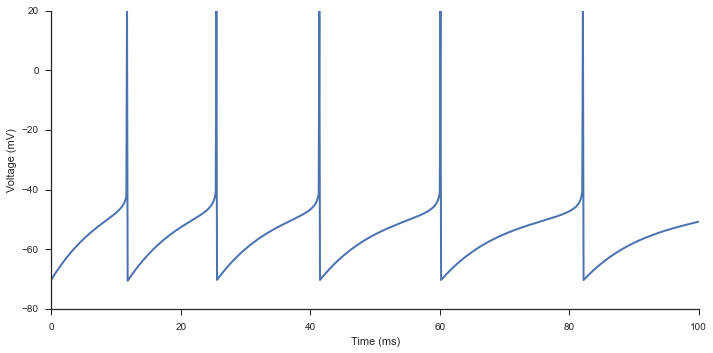

In [14]:
plt.plot(voltage.t / br.ms, vm / br.mV)
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
prettify()

Here's what the voltage trace looks like when we plot it.

- [NEST (NEural Simulation Tool)](http://www.nest-initiative.org/index.php/PyNEST)
- [MOOSE (Multiscale Object-Oriented Simulation Environment)](http://journal.frontiersin.org/article/10.3389/neuro.11.006.2008/abstract)
- [GENESIS (GEneral NEural SImulation System)](http://genesis-sim.org/userdocs/tutorial-python-scripting/tutorial-python-scripting.html)
- [NEVESIM (Neural EVEnt-based SIMulator)](http://journal.frontiersin.org/article/10.3389/fninf.2014.00070/abstract)
- [PCSIM (Parallel neural Circuit SIMulator)](http://www.lsm.tugraz.at/pcsim/)
- [Brainlab](http://journal.frontiersin.org/article/10.3389/neuro.11.016.2009/abstract)
- [Topographica](http://journal.frontiersin.org/article/10.3389/neuro.11.008.2009/abstract)
- [PyNN](http://neuralensemble.org/PyNN/)
- ...

NEURON and Brian aren't the only neural simulators
that work in Python; here are 8 more projects
that simulate biologically realistic neurons.
Some of them can simulate many of them,
in fact, and they are all impressive tools in their own right.
But to me they're not very satisfying.
This talk is about how to build *brain*,
but these tools are focused on building *neurons*.

Let me do a quick poll of the audience,
just a show of hands.
Hands up if you think that
human-like intelligence will emerge
if we create 86 billion neurons
like we've done in NEURON or Brian?
Okay, hands down.
Now, hands up if you think
human-like intelligence will emerge
if we connect the neurons together
according to the statistics of
the human brain; so, lots of local
connections, and a few far-ranging connections?

I agree, it doesn't seem very plausible.
In a way, what the neurons do is not that important;
what's important is how they're connected.

<img src="img/nengo.png" class="inline" width="40%">
$\quad$
<img src="img/nef.png" class="inline" width="40%">

Nengo is a neural simulator that focuses on
connects groups of neurons together
using a theoretical framework called
the Neural Engineering Framework,
or NEF for short.
We don't have time to go over all of the NEF,
I mostly want to show you a Nengo example,
but I want to give you some sense of it
with two useful analogies.

# Nengo is a *neural compiler*

<div class="fragment fade-out" data-fragment-index="1">

<code><pre>
int x = 3;
int y = x * x;
printf("%d squared is %d", x, y);
</pre></code>

$$\quad$$
    
$$\Downarrow$$

$$\quad$$

<code><pre>
...
	subq	$16, %rsp
	leaq	L_.str(%rip), %rdi
	movl	$3, -4(%rbp)
	movl	-4(%rbp), %eax
	imull	-4(%rbp), %eax
	movl	%eax, -8(%rbp)
	movl	-4(%rbp), %esi
	movl	-8(%rbp), %edx
	movb	$0, %al
	callq	_printf
	movl	$0, %edx
	movl	%eax, -12(%rbp)
...
</pre></code>

</div>

<div class="fragment fade-in" data-fragment-index="1" style="position:relative; top:-440px;">

<code><pre>
val = Node(output=0.3)
x = Ensemble(n_neurons=40, dimensions=1)
squared = Ensemble(n_neurons=40, dimensions=1)
Connection(val, x)
Connection(x, squared, function=lambda x: x * x)
</pre></code>
    
$$\quad$$
    
$$\Downarrow$$

$$\quad$$

<img src="img/network.svg" class="center" width="60%">

</div>

The first analogy is that Nengo is a neural compiler.

In computing, compilers allow us to write
programs in an understandable high-level language,
to be later compiled into machine code,
which is specific to your hardware.
Think about what the state of computing would be now
if we still had to program by typing in machine code.

Similarly, Nengo allows us to define
models in terms of what information is represented,
and how it's transformed.
Nodes are representations that is not neural,
so they're analogous to the current we injected earlier,
and Ensembles are populations of neurons
that collectively represent information.
When we connect a node to an ensemble,
we're determining the current that should be
injected into each cell such that
it represents the high-level value.
When we connect two ensembles together,
we're determining all of the connection weights
between the two populations such that
the second population represents
the value represented in the first population,
fed to this function.

Nengo gives us a level of abstraction,
like compilers do in computing.
Instead of having to determine
what currents should be injected in these cells,
and what weights should be used
to connect all of these neurons,
we instead say what information
should be represented, and how
those representations should be transformed.

In [64]:
import nengo

with nengo.Network(seed=1) as net:
    val = nengo.Node(output=0.3)
    x = nengo.Ensemble(40, dimensions=1)
    squared = nengo.Ensemble(40, dimensions=1)
    nengo.Connection(val, x)
    nengo.Connection(x, squared, function=lambda x: x * x)
    
    x_probe = nengo.Probe(x, synapse=0.03)
    sq_probe = nengo.Probe(squared, synapse=0.03)

In [65]:
sim = nengo.Simulator(net)
sim.run(1.0)

Simulation finished in 0:00:01.                                                 


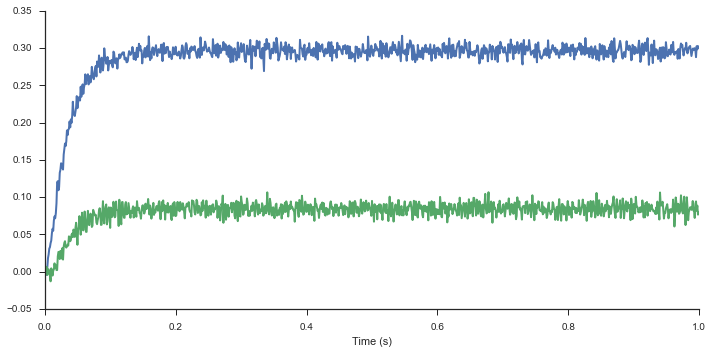

In [66]:
plt.plot(sim.trange(), sim.data[x_probe])
plt.plot(sim.trange(), sim.data[sq_probe])
plt.xlabel("Time (s)")
prettify()

In [67]:
val.output = lambda t: np.sin(t * 2 * np.pi)

Simulation finished in 0:00:01.                                                 


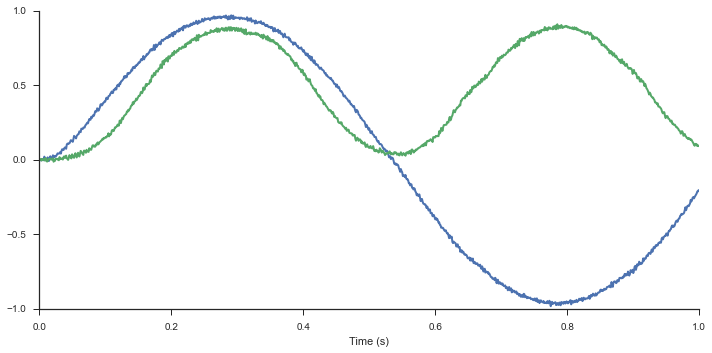

In [68]:
sim = nengo.Simulator(net)
sim.run(1.0)
plt.plot(sim.trange(), sim.data[x_probe])
plt.plot(sim.trange(), sim.data[sq_probe])
plt.xlabel("Time (s)")
prettify()

In [69]:
with net:
    v_pr = nengo.Probe(x.neurons[0], 'voltage')
    sp_pr = nengo.Probe(x.neurons, 'spikes')

Simulation finished in 0:00:01.                                                 


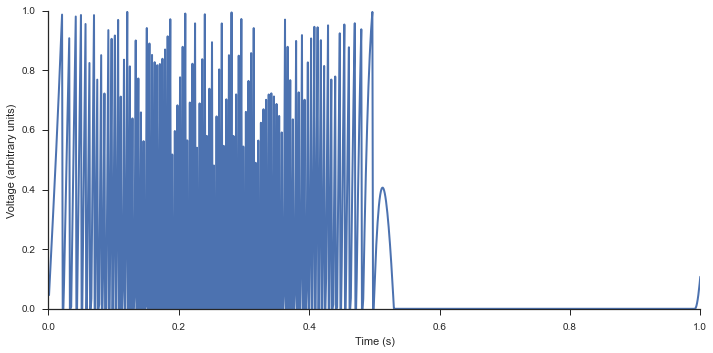

In [72]:
sim = nengo.Simulator(net)
sim.run(1.0)
plt.plot(sim.trange(), sim.data[v_pr])
plt.ylabel("Voltage (arbitrary units)")
plt.xlabel("Time (s)")
prettify()

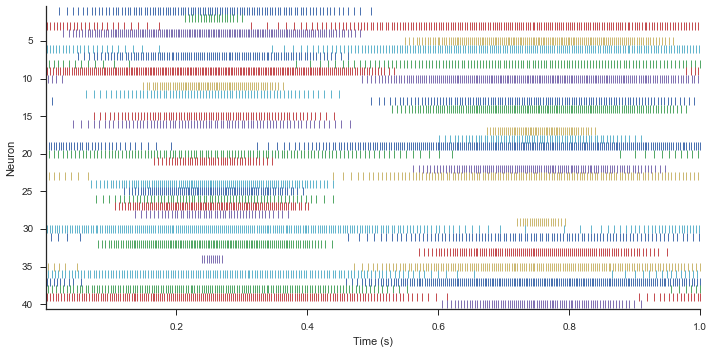

In [73]:
rasterplot(sim.trange(), sim.data[sp_pr])
plt.ylabel("Neuron")
plt.xlabel("Time (s)")
prettify()

Let's actually run this example.
The code is as you saw it before;
the Network object is just a way
of organizing models.
So we create the node and both ensembles
in this network,
then connect them together.
To get data from them, we add probes.
To run them, we create a simulator object,
and pass in the network.
Then after we run it, the data is available
in a dictionary, `sim.data`,
and we can plot it.

One big difference between this type of computing
and traditional computing
is that it's very dynamic;
it's unusual to represent an unchanging value.
So let's change this from representing
a number, to representing a sine wave.
*run*

These plots don't look like what we've plotted before,
so let me just prove that we are implementing
this math with neurons.
We can probe the voltages of a single neuron,
and the spikes from all of the neurons.
*run*

# Neural code $\approx$ binary code

<div class="fragment fade-out" data-fragment-index="1">

$$x = 13$$

$$a = 1101$$

$$d = 2^3 2^2 2^1 2^0$$

$$\hat{x} = 1 \times 8 + 1 \times 4 + 0 \times 2 + 1 \times 1 = 13$$

</div>

<div class="fragment fade-in" data-fragment-index="1" style="position:relative; top:-90px;">

$$x = 0.3$$

$$a = 23 Hz, 60 Hz, 3 Hz, ...$$

$$d = d_0, d_1, d_2, ...$$

$$\hat{x} = 23 \times d_0 + 60 \times d_1 + 3 \times d_2 + ... \approx 0.3$$

</div>

So now that we've seen Nengo run a bit,
the natural question is how does it work?
That brings me to the second analogy,
that the neural code is similar to binary code.

As most of us here know,
binary is essentially how computers
represent information.
Let's say we want to represent the value 13.
We can encode this as the binary number 1101.
We can decode this back to decimal
by essentially weighting each of these digits
with the power of two they encode.

In the NEF,
we consider the neural code to be very similar.
You can think of each bit in the binary case
as a neuron. In the binary case,
each bit encodes a single value,
and it's either true or false.
In the neural case,
each neuron also encodes a value,
but it's not just true or false;
the relatively amount of neural activity tells
us some information about that particular value.
Then decoding is essentially the same;
we weight the neural activity by certain weights
to recover the originally encoded value.

Let's visualize this another way.
First, binary coding.
On the x-axis, we have the possible encoded values.
On the y-axis, the 'activity' of each bit.
So, the most obvious is bit 0,
which alternates for each encoded value.
If you think about each encoded value,
we can recover it by
weighting the values and summing them.
*e.g.*
Now, neural coding.
On the x-axis, we again have the possible encoded values.
On the y-axis, the 'activity' of each neuron,
measured in the firing rate.
If we look at a value,
say 0.5,
we have a particular profile of activity
that is indicative of the value 0.5.
We figure out a single set of weights
so that, no matter what value we're trying to decode,
doing this weighted sum always gives us back
the encoded value.

<div class="fragment">
  <video preload="auto">
    <source src="img/spaun.mp4" type="video/mp4">
    Your browser does not support the video tag.
  </video>
</div>

<div class="fragment" style="text-align:center;">
  <a href="http://nengo.ca/build-a-brain/spaunvideos">Spaun videos</a>
  $\quad\cdot\quad$
  <a href="http://www.amazon.com/How-Build-Brain-Architecture-Architectures/dp/0199794545/">
    <img src="img/htbab.jpg" class="inline" width="100">
  </a>
</div>

Okay. Those were dense slides.
There's a lot more to Nengo and the NEF,
but those two analogies --
that it's a neural compiler
that represents information
analogously to binary coding --
are really the fundamentals.
These two ideas, plus a few more ideas,
plus a decade or so of research,
has led to models of working memory,
motor control, vision,
all respecting the constraints of biology
but actually working.
We put all of these models together
into a huge model called Spaun,
which I unfortunately don't have time to talk about,
but please check out some videos here,
and if you want to know more about how it was made,
check out my supervisor's most recent book,
How to Build a Brain.

In [6]:
%%writefile oscillator.py

import nengo
import numpy as np

model = nengo.Network('Oscillator', seed=1)

tau = 0.01
r = 4

def feedback(x):    
    return [-tau*r*x[1]+x[0], tau*r*x[0]+x[1]]

def osc_shape(x):
    theta = np.arctan2(x[1], x[0])
    r = 2 - 2 * np.sin(theta) + np.sin(theta)*np.sqrt(np.abs(np.cos(theta)))/(np.sin(theta)+1.4)
    return -r*np.cos(theta), r*np.sin(theta)

with model:
    stim = nengo.Node(lambda t: [.5,.5] if t<.02 else [0,0])    
    oscillator = nengo.Ensemble(1000, dimensions=2)
    shape = nengo.Ensemble(100, dimensions=2, radius=4)
    
    nengo.Connection(stim, oscillator)
    nengo.Connection(oscillator, oscillator, function=feedback, synapse=tau)
    nengo.Connection(oscillator, shape, function=osc_shape, synapse=tau)

Overwriting oscillator.py


In [7]:
import nengo_viz
nengo_viz.Viz('oscillator.py').start()

{'mask': 1, 'datalen': 2, 'opcode': 8, 'rsv': 0, 'fin': 1}
{'mask': 1, 'datalen': 2, 'opcode': 8, 'rsv': 0, 'fin': 1}
{'mask': 1, 'datalen': 2, 'opcode': 8, 'rsv': 0, 'fin': 1}
{'mask': 1, 'datalen': 2, 'opcode': 8, 'rsv': 0, 'fin': 1}
{'mask': 1, 'datalen': 2, 'opcode': 8, 'rsv': 0, 'fin': 1}
{'mask': 1, 'datalen': 2, 'opcode': 8, 'rsv': 0, 'fin': 1}
{'mask': 1, 'datalen': 2, 'opcode': 8, 'rsv': 0, 'fin': 1}
{'mask': 1, 'datalen': 2, 'opcode': 8, 'rsv': 0, 'fin': 1}
{'mask': 1, 'datalen': 2, 'opcode': 8, 'rsv': 0, 'fin': 1}
{'mask': 1, 'datalen': 2, 'opcode': 8, 'rsv': 0, 'fin': 1}
{'mask': 1, 'datalen': 2, 'opcode': 8, 'rsv': 0, 'fin': 1}
{'mask': 1, 'datalen': 2, 'opcode': 8, 'rsv': 0, 'fin': 1}


127.0.0.1 - - [06/Apr/2015 23:34:46] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [06/Apr/2015 23:34:46] "GET /static/viz_pointer.css HTTP/1.1" 200 -
127.0.0.1 - - [06/Apr/2015 23:34:46] "GET /static/viz_slider.css HTTP/1.1" 200 -
127.0.0.1 - - [06/Apr/2015 23:34:46] "GET /static/viz_raster.css HTTP/1.1" 200 -
127.0.0.1 - - [06/Apr/2015 23:34:46] "GET /static/viz_value.css HTTP/1.1" 200 -
127.0.0.1 - - [06/Apr/2015 23:34:46] "GET /static/main.css HTTP/1.1" 200 -
127.0.0.1 - - [06/Apr/2015 23:34:46] "GET /static/viz.css HTTP/1.1" 200 -
127.0.0.1 - - [06/Apr/2015 23:34:46] "GET /static/viz_sim_control.css HTTP/1.1" 200 -
127.0.0.1 - - [06/Apr/2015 23:34:46] "GET /static//lib/css/bootstrap.min.css HTTP/1.1" 200 -
127.0.0.1 - - [06/Apr/2015 23:34:46] "GET /static/viz_netgraph.css HTTP/1.1" 200 -
127.0.0.1 - - [06/Apr/2015 23:34:46] "GET /static/lib/js/jquery-2.1.3.min.js HTTP/1.1" 200 -
127.0.0.1 - - [06/Apr/2015 23:34:46] "GET /static/lib/js/interact-1.2.4.js HTTP/1.1" 200 -
127.0.0.1 - - [06/Apr

KeyboardInterrupt: 

I want to finish off by showing one final example,
that uses an interactive visualizer that we've been
working on lately, and will hopefully be released soon.
I hope that it will also prove that
Nengo and brain modelling are nothing to be scared of,
and won't become the next Skynet.
So it's basically just two ensembles,
one connected to itself, and one connected to the other.
The functions on those connections are complicated,
and we have a node that for now doesn't do anything.

Here's our interactive environment.
We can call up plots of different elements,
so let's look *blah*.
We can control the output of the node with these sliders.
When we start the network (it takes a little while to build)
we move he sliders a bit to kick it off...
and there we go! A lovely oscillator.

If you want to learn more,
head to `nengo.ca`.
Thank you for listening,
and I think I have time for a few questions!